In [28]:
from collections import defaultdict
import numpy as np
import pdb
import dill
# from sklearn.datasets.samples_generator import make_blobs
import random
from itertools import combinations, product
from scipy.special import gamma
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform, euclidean
import matplotlib.pyplot as plt
from sklearn import datasets
from tqdm import tqdm
from math import sqrt
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import f1_score, confusion_matrix, silhouette_score, davies_bouldin_score
import seaborn as sn

In [29]:
class Lorentz:
    def __init__(self, s = 10, r = 28, b = 8/3):
        self.s = s
        self.r = r
        self.b = b

    #Differential equations of a Lorenz System
    def X(self, x, y, s):
        return s * (y - x)

    def Y(self, x, y, z, r):
        return (-x) * z + r * x - y

    def Z(self, x, y, z, b):
        return x * y - b * z

    #RK4 for the differential equations
    def RK4(self, x, y, z, s, r, b, dt):
        k_1 = self.X(x, y, s)
        l_1 = self.Y(x, y, z, r)
        m_1 = self.Z(x, y, z, b)

        k_2 = self.X((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), s)
        l_2 = self.Y((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), (z + m_1 * dt * 0.5), r)
        m_2 = self.Z((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), (z + m_1 * dt * 0.5), b)

        k_3 = self.X((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), s)
        l_3 = self.Y((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), (z + m_2 * dt * 0.5), r)
        m_3 = self.Z((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), (z + m_2 * dt * 0.5), b)

        k_4 = self.X((x + k_3 * dt), (y + l_3 * dt), s)
        l_4 = self.Y((x + k_3 * dt), (y + l_3 * dt), (z + m_3 * dt), r)
        m_4 = self.Z((x + k_3 * dt), (y + l_3 * dt), (z + m_3 * dt), b)

        x += (k_1 + 2 * k_2 + 2 * k_3 + k_4) * dt * (1/6)
        y += (l_1 + 2 * l_2 + 2 * l_3 + l_4) * dt * (1/6)
        z += (m_1 + 2 * m_2 + 2 * m_3 + m_4) * dt * (1/6)

        return (x, y, z)

    def generate(self, dt, steps):
        #Initial values and Parameters
        x_0, y_0, z_0 = 1, 1, 1

        #RK4 iteration
        x_list = [x_0]
        y_list = [y_0]
        z_list = [z_0]

        i = 0

        while i < steps:
            x = x_list[i]
            y = y_list[i]
            z = z_list[i]

            position = self.RK4(x, y, z, self.s, self.r, self.b, dt)

            x_list.append(position[0])
            y_list.append(position[1])
            z_list.append(position[2])

            i += 1

        x_array = np.array(x_list)
        y_array = np.array(y_list)
        z_array = np.array(z_list)

        return x_array, y_array, z_array

In [30]:
lorents = Lorentz()
data, _, _ = Lorentz().generate(0.1, 100000)
data = (data - data.min()) / (data.max() - data.min())

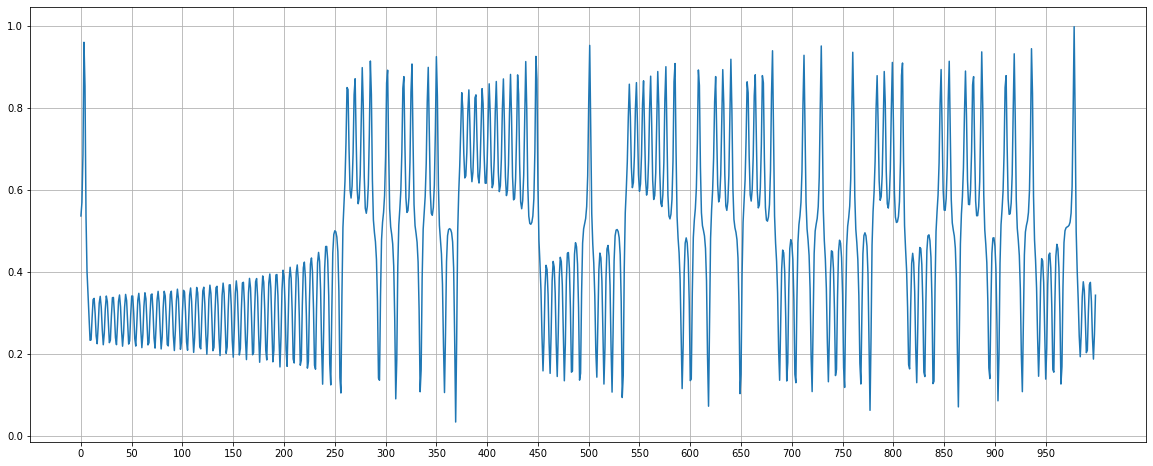

In [31]:
plt.figure(figsize=(20, 8))
plt.plot(data[:1000])
plt.xticks([i for i in range(0, 1000, 50)])
plt.grid()
plt.show()

In [52]:
from itertools import product

def GenerateMotifsByPattern(pattern, t):
  # Returns motifs according to given pattern
  L = len(pattern)
  idx = []
  idx.append(0)
  for i in range(L):
    idx.append(idx[len(idx) - 1] + pattern[i])
  motifs = []
  while idx[len(idx) - 1] != t + 1:
    motifs.append(idx.copy())
    for i in range(len(idx)):
      idx[i] += 1
  return motifs

def IteratePatterns(patterns, pattern, i, L, sum, Kmax):
  # Generate all patterns with sum <= Kmax and length = L - 1
  if i == L - 1:
    patterns.append(pattern.copy())
  else:
    for j in range(1, Kmax - sum + 1):
      pattern[i] = j
      IteratePatterns(patterns, pattern, i + 1, L, sum + j, Kmax)

# def GenPatterns(patterns, pattern, i, L, Kmax):
#   if i == L - 1:
#     patterns.append(pattern.copy())
#   else:
#     for j in range(1, Kmax + 1):
#       pattern[i] = j
#       GenPatterns(patterns, pattern, i + 1, L, Kmax)

def GenPatterns(L, x):
    elements = range(1, x+1)  # Создаем последовательность элементов от 1 до x
    sequences = product(elements, repeat=L)  # Генерируем все возможные комбинации длиной L
    return sequences


def GenerateAllMotifs(Kmax, L, t):
  print(1020030)
  # Returns map [pattern, [motifs...]]
  patterns = []
  pattern = []
  for i in range(L - 1):
    pattern.append(0)
  # IteratePatterns(patterns, pattern, 0, L, 0, Kmax)
  patterns = GenPatterns(L - 1, Kmax)
  # print(len(patterns))
  motifsByPatterns = []
  for p in patterns:
    motifs = GenerateMotifsByPattern(p, t)
    motifsByPatterns.append([p, motifs])
  return motifsByPatterns


In [89]:
from statistics import mean
from wishart_lib import Wishart
TRAIN_SIZE = 1000
TEST_SIZE = 200
size = len(data)
train_data = data[:TRAIN_SIZE]
test_data = data[TRAIN_SIZE:TRAIN_SIZE + TEST_SIZE]
print(size)

100001


In [87]:
def get_val_for_pattern_and_pos(data: np.array, pattern: list, pos: int, bad):
    val = []
    sum = 0
    for i in range(len(pattern) - 1, -1, -1):
      sum += pattern[i]
      val.append(data[pos - sum])
      if bad[pos - sum]:
          return np.array([])
    val = val[::-1]
    return np.array(val)

def get_val_for_motifs(data: np.array, motif: list, bad):
    val = []
    for i in motif:
        val.append(data[i])
        if bad[i]:
            return np.array([])
    return np.array(val)


def mode(a):
    return max(set(a), key=a.count)

def is_predictable(a):
    return abs(mean(a) - mode(a)) / mode(a) <= 0.1

def get(a):
    return abs(mean(a) - mode(a)) / mode(a)

In [90]:
from itertools import groupby
WISHART_R = 10
WISHART_U = 0.2
def get_centers(x_train):
    N = len(x_train[0])
    wishart = Wishart(WISHART_R, WISHART_U)
    labels = wishart.fit(x_train)
    sorted_by_cluster = sorted(range(len(labels)), key=lambda x: labels[x])
    centers = []
    for wi, cluster in groupby(sorted_by_cluster, lambda x: labels[x]):
        cluster = list(cluster)
        center = np.full(N, 0.0)
        for i in cluster:
            center += x_train[i]
        centers.append(center / len(cluster))

    return centers


def get_all_centers_for_patterns(data, L: int = 3, kmax: int = 10):
    centers = defaultdict(list)
    t = len(data)
    print(t)
    bad = np.array([0 for i in range(t)])
    for pattern, all_motifs  in GenerateAllMotifs(kmax, L, t - 1):
        print(pattern)
        all_val = [get_val_for_motifs(data, motif, bad) for motif in all_motifs]
        all_val = [i - [i[0]] * len(i) for i in all_val if len(i)]
        centers[pattern].append(get_centers(all_val))
    return centers

In [91]:
centers = get_all_centers_for_patterns(train_data, L = 4)

1000
1020030
(1, 1, 1)
(1, 1, 2)
(1, 1, 3)
(1, 1, 4)
(1, 1, 5)
(1, 1, 6)
(1, 1, 7)
(1, 1, 8)
(1, 1, 9)
(1, 1, 10)
(1, 2, 1)
(1, 2, 2)
(1, 2, 3)
(1, 2, 4)
(1, 2, 5)
(1, 2, 6)
(1, 2, 7)
(1, 2, 8)
(1, 2, 9)
(1, 2, 10)
(1, 3, 1)
(1, 3, 2)
(1, 3, 3)
(1, 3, 4)
(1, 3, 5)
(1, 3, 6)
(1, 3, 7)
(1, 3, 8)
(1, 3, 9)
(1, 3, 10)
(1, 4, 1)
(1, 4, 2)
(1, 4, 3)
(1, 4, 4)
(1, 4, 5)
(1, 4, 6)
(1, 4, 7)
(1, 4, 8)
(1, 4, 9)
(1, 4, 10)
(1, 5, 1)
(1, 5, 2)
(1, 5, 3)
(1, 5, 4)
(1, 5, 5)
(1, 5, 6)
(1, 5, 7)
(1, 5, 8)
(1, 5, 9)
(1, 5, 10)
(1, 6, 1)
(1, 6, 2)
(1, 6, 3)
(1, 6, 4)
(1, 6, 5)
(1, 6, 6)
(1, 6, 7)
(1, 6, 8)
(1, 6, 9)
(1, 6, 10)
(1, 7, 1)
(1, 7, 2)
(1, 7, 3)
(1, 7, 4)
(1, 7, 5)
(1, 7, 6)
(1, 7, 7)
(1, 7, 8)
(1, 7, 9)
(1, 7, 10)
(1, 8, 1)
(1, 8, 2)
(1, 8, 3)
(1, 8, 4)
(1, 8, 5)
(1, 8, 6)
(1, 8, 7)
(1, 8, 8)
(1, 8, 9)
(1, 8, 10)
(1, 9, 1)
(1, 9, 2)
(1, 9, 3)
(1, 9, 4)
(1, 9, 5)
(1, 9, 6)
(1, 9, 7)
(1, 9, 8)
(1, 9, 9)
(1, 9, 10)
(1, 10, 1)
(1, 10, 2)
(1, 10, 3)
(1, 10, 4)
(1, 10, 5)
(1, 10, 6)
(1, 10, 7)
(

In [92]:
print(centers[(1, 1, 1)][0])

[array([ 0.        , -0.0406973 , -0.09994791, -0.13252601]), array([0.        , 0.06428855, 0.15911128, 0.20753207]), array([ 0.        , -0.16018729, -0.25259436, -0.27667078]), array([0.        , 0.11534704, 0.16249269, 0.15567802]), array([ 0.        , -0.04876156, -0.03993277,  0.01807039]), array([0.        , 0.05291249, 0.16129558, 0.2906808 ]), array([ 0.        , -0.06133297, -0.17562464, -0.29668891]), array([ 0.        , -0.08874565, -0.25290332, -0.30366754])]


In [106]:
def get_val_for_pattern_and_pos(data: np.array, pattern: list, pos: int, bad):
    val = []
    sum = 0
    for i in range(len(pattern) - 1, -1, -1):
      sum += pattern[i]
      val.append(data[pos - sum])
      if bad[pos - sum]:
          return np.array([])
    val = val[::-1]
    return np.array(val)

def get_val_for_motifs(data: np.array, motif: list, bad):
    val = []
    for i in motif:
        val.append(data[i])
        if bad[i]:
            return np.array([])
    return np.array(val)


def mode(a):
    return max(set(a), key=a.count)

def is_predictable(a):
    return abs(mean(a) - mode(a)) / mode(a) <= 0.1

def get(a):
    return abs(mean(a) - mode(a)) / mode(a)

def base_prediction(data, h: int, L: int = 3, kmax: int = 10, eps: float = 0.1):
    t = len(data)
    prediction = data
    prediction = np.resize(prediction, t + h)
    bad = np.array([0 for i in range(t + h)])
    # print(prediction)
    for i in range(t):
        prediction[i] = data[i]
    possible_values = [[] for i in range(h)]
    d = []
    steps = 0
    for i in range(h):
        for pattern, all_motifs  in GenerateAllMotifs(kmax, L, t + i - 1):
            val_for_pattern = get_val_for_pattern_and_pos(prediction, pattern, t + i, bad)
            # print(val_for_pattern)
            if len(val_for_pattern) == 0:
                continue
            # start = val_for_pattern[0]
            # val_for_pattern = val_for_pattern - [val_for_pattern[0]] * len(val_for_pattern)
          
            # all_val = [get_val_for_motifs(prediction, motif, bad) for motif in all_motifs]
            # all_val = [i - [i[0]] * len(i) for i in all_val if len(i)]
            # centers = get_centers(all_val)

            for c in centers[pattern][0]:
              if len(c) == 0:
                  continue
              steps += 1
              dist = np.linalg.norm(c[:-1] - val_for_pattern)
              d.append(dist)
              if dist < eps:
                  
                  print(val_for_pattern)
                  print(c)
                  print(dist)
                #   print(start)
                #   possible_values[i].append(c[-1] + start)
                  possible_values[i].append(c[-1])
                
        # sorted(possible_values)mean
        # print("aa")
        # print(len(possible_values[i]))
        if len(possible_values[i]):
            # print(len(possible_values[i]),  mean(possible_values[i]))
            # print(get(possible_values[i]))
            # if len(set(Wishart(WISHART_R, WISHART_U).fit([[el] for el in possible_values[i]]))) < 4:
            prediction[t + i] = mean(possible_values[i])
            # else:
            #     bad[t + i] = 1
        else:
            bad[t + i] = 1
        # print(prediction[t + i])
    print(sorted(d)[len(d) // 2])
    print(max(d))
    print(steps)
    return [prediction, bad]


# base_prediction(test_data[-40:], 5)


1000
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
1020030
0.5557614257235686
1.6428436257784966
23695
[0.53696553 0.57039027 0.68672766 0.96067405 0.8537592  0.53566135
 0.40106146 0.34368356 0.28620523 0.23358731 0.23472149 0.2881094
 0.33301958 0.3358

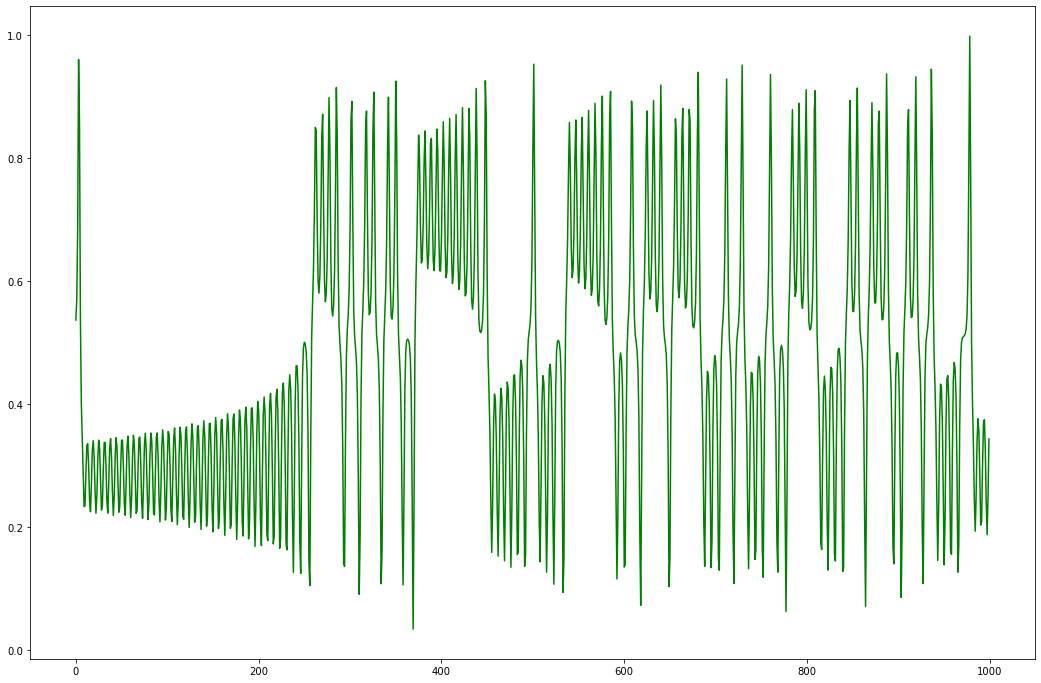

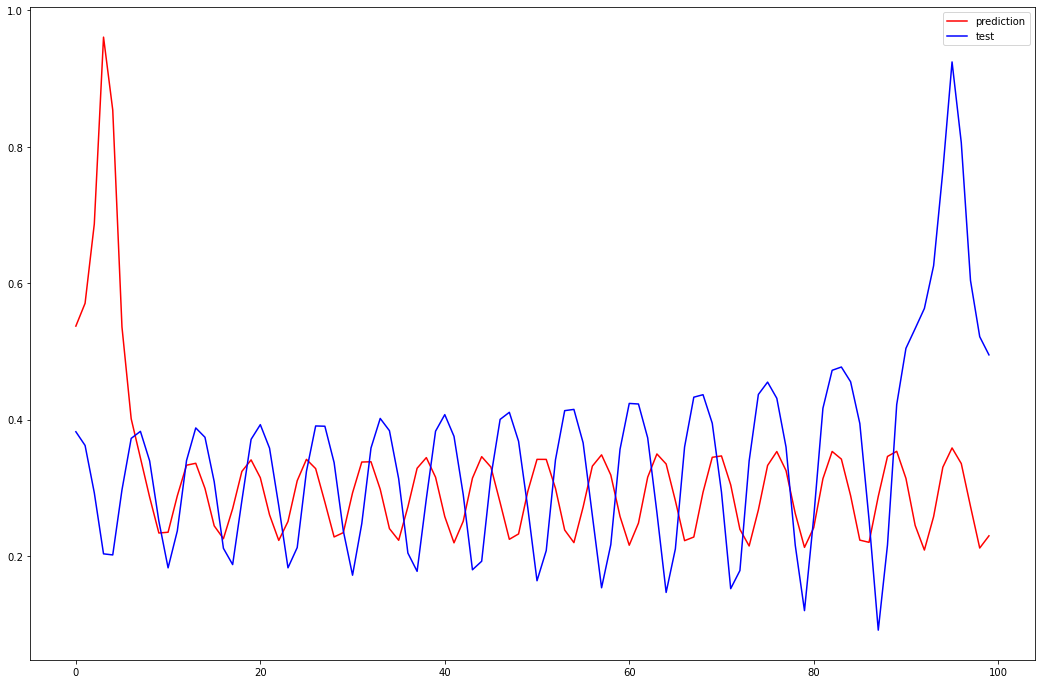

In [108]:
h = 100
print(len(train_data))
prediction, bad = base_prediction(train_data, h, L=4, eps=0.05)

# print(prediction[-h:])
plt.figure(figsize=(18, 12))
plt.plot(list(train_data), 'g', label='prediction')
print(prediction[-h:])
print(bad[-h:])
plt.figure(figsize=(18, 12))
plt.plot(prediction[-h:], 'r', label='prediction')
plt.plot(list(test_data[:h]), 'b', label='test')
plt.legend(loc='best')
# plt.scatter(list(range(0, h)), list(prediction[-h:]), s=50, c='r', label='prediction')
# # plt.plot(test_data, 'b', label='prediction')
plt.show()